In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "5" # 학습 환경에 따라 변경

## Import

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import resnet152
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore') 

C:\Users\chosun\anaconda3\envs\ML\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [4]:
CFG = {
    'IMG_HEIGHT_SIZE':32,
    'IMG_WIDTH_SIZE':128,
    'EPOCHS':20,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':128,
    'NUM_WORKERS':20, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

In [5]:
torch.__version__

'1.12.1'


## Fixed RandomSeed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [7]:
df = pd.read_csv('./train.csv')

In [8]:
len(df)

76888

In [9]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]
len(train_v1)

23703

In [10]:
# 제공된 학습데이describe2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.1, random_state=CFG['SEED'])

In [11]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2])
#val = pd.concat([val_v1, val_v2])
print(len(train), len(val))

71569 5319


In [12]:
df_len_count = pd.DataFrame(train['len'].value_counts())
df_len_count.reset_index(inplace=True)
df_len_count.columns = ['len', 'len_count']

display(df_len_count)

,len,len_count
0,2,25756
1,1,23703
2,3,12134
3,4,9036
4,5,919
5,6,21


<AxesSubplot: xlabel='len', ylabel='len_count'>

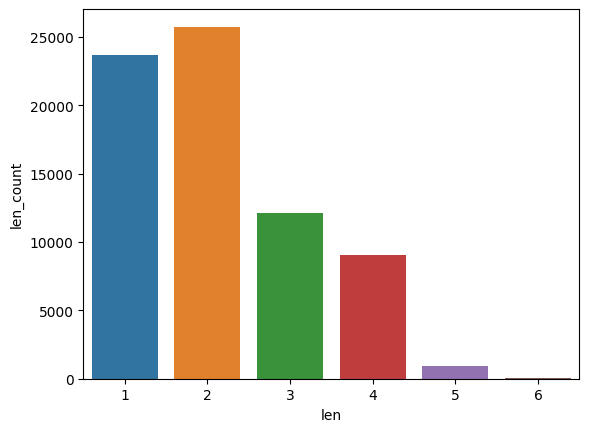

In [13]:
import seaborn as sns
sns.barplot(data=df_len_count, x='len', y='len_count')

## Get Vocabulary

In [14]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']]
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt))))
print(len(letters))

2349


In [15]:
vocabulary = ["-"] + letters
print(len(vocabulary))
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

2350


## CustomDataset

In [16]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        image = Image.open(self.img_path_list[index]).convert('RGB')
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            #transforms.RandomResizedCrop((CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE'])),
            transforms.ColorJitter(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def val_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'],CFG['IMG_WIDTH_SIZE'])),
            transforms.ColorJitter(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [17]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, False)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)

In [18]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([128, 3, 32, 128]) ('초보자', '양심', '뼙', '정신적', '정도', '소화', '일정하다', '찹', '지방', '취소', '울리다', '이래', '발휘하다', '금', '찍히다', '핀', '규', '배', '맛보다', '깔끔하다', '가져가다', '할아버지', '넉', '소규모', '손톱', '헐', '날카롭다', '쐤', '꾜', '온', '메우다', '체계적', '바치다', '학위', '대합실', '체온', '연기', '판', '칠십', '줄다', '고등학교', '단점', '떨어지다', '빗방울', '인간적', '온종일', '실현되다', '절', '가운데', '년', '이빨', '낢', '인천', '색다르다', '소문', '전문직', '낯설다', '투표', '살아나다', '넓', '이용자', '법', '닢', '안다', '연구실', '반장', '지나가다', '깨다', '기억', '숫자', '회견', '포장', '단지', '온갖', '볏', '쉬다', '퍼지다', '지', '륫', '술', '구분되다', '급증하다', '아래쪽', '행복', '북', '차다', '귿', '예습', '평양', '곈', '전시되다', '스케줄', '뎨', '방법', '지다', '홍', '쉼', '터미널', '흥', '특', '안', '그만', '엑', '일기', '급격히', '숫', '올', '그', '전하다', '쁠', '어쩜', '투표', '초등학교', '육', '세', '시작되다', '어떡하다', '바', '소극적', '삼', '밝히다', '여', '팸', '출근', '년', '한여름', '각', '귀국하다')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


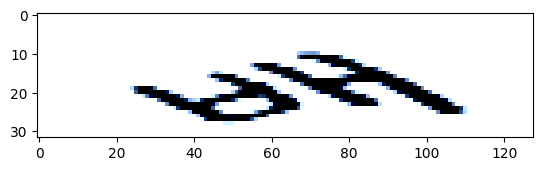

In [19]:
img = image_batch[17]
img = img.cpu().numpy().T
img = np.swapaxes(img, 0, 1)
plt.imshow(img)


In [20]:
os.getcwd()

'D:\\Code\\Lab\\Text_Recognition'

In [21]:
from PIL import Image
img = Image.open("./train/TRAIN_13845.png")
img.show()

In [22]:
image_batch, text_batch = iter(val_loader).next()
print(image_batch.size(), text_batch)

torch.Size([128, 3, 32, 128]) ('지점', '한때', '현대인', '띄우다', '지도자', '자신', '여자', '숨기다', '신고하다', '근거하다', '공연되다', '바람', '언어', '대도시', '아쉬움', '선수', '나가다', '미소', '일요일', '전통', '그루', '수염', '안다', '아니', '문장', '화면', '차다', '불법', '소프트웨어', '부러워하다', '코스', '가만있다', '보조', '살리다', '대규모', '겪다', '전부', '닦다', '예술적', '필연적', '수면', '열정', '손톱', '숙제', '가끔', '공연', '완전', '강도', '두세', '줄다', '기혼', '운동복', '힘껏', '거리', '믿다', '고려', '깔다', '독하다', '손쉽다', '고등학교', '운전자', '출판', '일주일', '뒷골목', '인하다', '성적', '만두', '관계없이', '발생하다', '업무', '배경', '탁월하다', '연구실', '가다', '성공적', '간부', '자매', '햇살', '의복', '소리치다', '멀어지다', '연기되다', '칼국수', '아래층', '바늘', '머릿속', '이상', '굽히다', '화면', '신화', '강남', '취직', '동전', '외국어', '떨어지다', '러시아', '문제', '오페라', '오늘', '기름', '축구공', '수출', '끄다', '무엇', '생각되다', '당시', '엉망', '으레', '지도', '도로', '회색', '아니하다', '체중', '주먹', '마련', '소비하다', '참여하다', '이르다', '안경', '목숨', '씩씩하다', '인구', '일주일', '창고', '요리', '운동화', '고려하다', '오다')


## Denoising

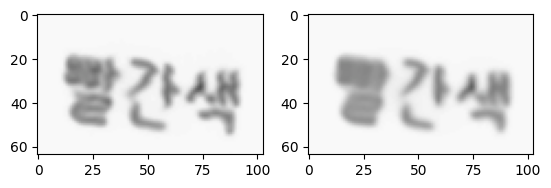

In [23]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread("train/TRAIN_00000.png", cv2.IMREAD_COLOR)
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()

## Model Define

In [24]:
class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size

        resnet = resnet152(pretrained=True)
        resnet_modules = list(resnet.children())[:-3]
        self.feature_extract = nn.Sequential(
            *resnet_modules,
            nn.Conv2d(1024, 1024, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        self.linear1 = nn.Linear(2048, rnn_hidden_size)
        
        # RNN
        self.rnn = nn.RNN(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, x):
        # CNN
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x)
        
        # RNN
        x, hidden = self.rnn(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output

## Define CTC Loss

In [25]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [26]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [27]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [28]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [29]:
def compute_acc(text_batch, text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.T # [batch_size, T]

    check = []; cnt = 0
    for text_tokens, answer in zip(text_batch_tokens, text_batch):
        text = [idx2char[int(idx)] for idx in text_tokens]
        text = "".join(text)
        
        check.append(1 if correct_prediction(text) == answer else 0)
            
    return check


## Training Recode

In [30]:
from datetime import datetime
current_epoch = 1
recode_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss',
                                 'train_acc', 'val_acc', 'best_loss',
                                  'best_acc'])
dir_name = datetime.now().strftime("%Y%m%d_%H%M%S")
fig, axes = plt.subplots(1, 2)
plt.close(fig)

In [31]:
def Recode(epoch, model, train_loss, val_loss, train_acc, val_acc, best_loss, best_acc, model_save=False):
    global recode_df, fig, axes
    
    # Data Write
    os.makedirs(f"./result/{dir_name}", exist_ok=True)
    new_data = {
        "epoch" : epoch,
        "train_loss" : train_loss,
        "val_loss" : val_loss,
        "train_acc" : train_acc,
        "val_acc" : val_acc,
        "best_loss" : best_loss,
        "best_acc" : best_acc
    }
    
    recode_df = recode_df.append(new_data,  ignore_index=True)
    recode_df.to_csv(f'./result/{dir_name}/recode.csv', index=False)
    
    
    # Data Visualization 
    os.makedirs(f"./result/{dir_name}/plot", exist_ok=True)
    fig, axes = plt.subplots(1, 2)
    fig = plt.figure(figsize=(20, 7))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(recode_df['train_loss'].to_list(), label="train loss")
    ax1.plot(recode_df['val_loss'].to_list(), label="val loss")
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(recode_df['train_acc'], label="train Accuracy")
    ax2.plot(recode_df['val_acc'], label="val Accuracy")
    ax2.legend()
    #plt.close(fig)
    #plt.ioff()
    
    if os.path.isfile(f"./result/{dir_name}/plot/loss_and_acc.png"):
        os.remove(f"./result/{dir_name}/plot/loss_and_acc.png")
    plt.savefig(f"./result/{dir_name}/plot/loss_and_acc.png")
    
    # Write Hyperparameter
    if epoch == 1:
        with open(f"./result/{dir_name}/train.txt",'w',encoding='UTF-8') as f:
            for key, values in CFG.items():
                f.write(f"{key} {values}" + "\n")
         
    if model_save:
        torch.save(model, f"./result/{dir_name}/model.pt")
    
    

## Train

In [32]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    global current_epoch
    model.to(device)
    
    best_model = None
    early_stop = 5
    
    if current_epoch != 1:
        tmp = pd.read_csv(f'./result/{dir_name}/recode.csv')
        best_acc = tmp['best_loss'][current_epoch-2]
        best_loss = tmp['best_acc'][current_epoch-2]
        if os.path.isfile(f"./result/{dir_name}/model.pt"):
            model = torch.load(f"./result/{dir_name}/model.pt", map_location= device)
    else:
        best_acc = -1
        best_loss = 1e9
        
        
    for epoch in range(current_epoch, current_epoch + CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_acc = []
        model_save = False
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                text_batch_logits = model(image_batch)
                loss = compute_loss(text_batch, text_batch_logits)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_acc += compute_acc(text_batch, text_batch_logits)
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        
        _train_acc = 100. * sum(train_acc) / len(train_loader.dataset)
        _val_loss, _val_acc = validation(model, val_loader, device)
        
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        print(f'Epoch : [{epoch}] Train Accuracy : [{_train_acc:.5f}] Val Accuracy : [{_val_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss or best_acc < _val_acc:
            early_stop += 1
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            
        if best_acc < _val_acc:
            best_acc = _val_acc
            best_model = model
            model_save = True
            
        early_stop -= 1
        current_epoch += 1
        Recode(epoch, model, _train_loss, _val_loss, _train_acc, _val_acc, best_loss, best_acc, model_save)
        
        if early_stop == 0:
            break
    
    return best_model

## Validation

In [33]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []; val_acc = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            with torch.cuda.amp.autocast():
                text_batch_logits = model(image_batch)
                loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
            val_acc += compute_acc(text_batch, text_batch_logits)
    
    _val_loss = np.mean(val_loss)
    _val_acc = 100. * sum(val_acc) / len(val_loader.dataset)
    return _val_loss, _val_acc

In [62]:
model = torch.hub.load('baudm/parseq', 'parseq', pretrained=True).eval()
model.text_embed.embedding = torch.nn.Embedding(2350, 384)


Using cache found in C:\Users\chosun/.cache\torch\hub\baudm_parseq_main


In [63]:
model

PARSeq(
  (encoder): Encoder(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(4, 8), stride=(4, 8))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=1536, out_features=384, b

## Run!!

In [48]:
#model = RecognitionModel()
#model.eval()
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=0.3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

In [64]:
from torchsummary import summary
summary(model, input_size=(3, CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']), batch_size=CFG['BATCH_SIZE'], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 384, 8, 16]          37,248
          Identity-2            [128, 128, 384]               0
        PatchEmbed-3            [128, 128, 384]               0
           Dropout-4            [128, 128, 384]               0
          Identity-5            [128, 128, 384]               0
         LayerNorm-6            [128, 128, 384]             768
            Linear-7           [128, 128, 1152]         443,520
           Dropout-8         [128, 6, 128, 128]               0
            Linear-9            [128, 128, 384]         147,840
          Dropout-10            [128, 128, 384]               0
        Attention-11            [128, 128, 384]               0
         Identity-12            [128, 128, 384]               0
         Identity-13            [128, 128, 384]               0
        LayerNorm-14            [128, 1

In [65]:
infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/560 [00:00<?, ?it/s]

RuntimeError: target_lengths must be of size batch_size

In [59]:
model = torch.load(f"./result/{dir_name}/model.pt", map_location= device)

## Inference

In [40]:
test = pd.read_csv('./test.csv')

In [41]:
test_dataset = CustomDataset(test['img_path'].values, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

In [42]:
image_batch = iter(test_loader).next()
print(image_batch.size())

torch.Size([128, 3, 32, 128])


In [59]:
output = model(image_batch)

In [60]:
output[0].size()

torch.Size([26, 95])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


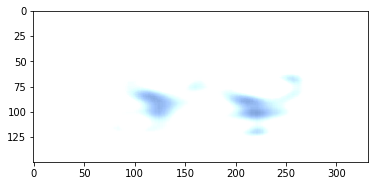

In [150]:
img = image_batch[206]
img = img.cpu().numpy().T
img = np.swapaxes(img, 0, 1)
plt.imshow(img)


In [62]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch)
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [63]:
predictions = inference(model, test_loader, device)

  0%|          | 0/580 [00:00<?, ?it/s]

## Submission

In [68]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [69]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [70]:
submit.to_csv('./submission4.csv', index=False)

In [71]:
predictions

['-날-------말--------',
 '-상-------황--------',
 '-받-아---들---이--다---',
 '-바------구----늬----',
 '-살----------------',
 '-빼----놓-----다-----',
 '-인---식---하---다----',
 '-센------터---------',
 '-소------풍---------',
 '-광--------주-------',
 '-나-------낙--------',
 '-위-------험--------',
 '-도-------도--------',
 '-술------표---------',
 '-괴-로-워----하---다---',
 '-카-------드--------',
 '-합-----치치--다다-----',
 '-다---정--하하--다다----',
 '-톤-------자자-------',
 '-가--능----하----다---',
 '-호-------주--------',
 '-발---전---되---다----',
 '-피----우----다------',
 '-스----웨-----터-----',
 '-시---작---되---다----',
 '-겨-------울--------',
 '-예--------선-------',
 '-한----국-----말-----',
 '-세---워---지---다----',
 '-비----방----밥------',
 '-좋------다다--------',
 '-남-대---문---시---장--',
 '-보---수------적-----',
 '-사----진-----기-----',
 '-내---리-----다다-----',
 '-핑------핑---------',
 '-맛---없----다다------',
 '-특----별-----히-----',
 '-우-------선선-------',
 '-대-----답답---------',
 '-학--------생-------',
 '-여------덟---------',
 '-본-------질--------',
 '-현-------

In [39]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,id,img_path,label
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색
1,TRAIN_00001,./train/TRAIN_00001.png,머
2,TRAIN_00002,./train/TRAIN_00002.png,차차
3,TRAIN_00003,./train/TRAIN_00003.png,써
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다
